# 1. Graph Construction

In [ ]:
import networkx as nx
from torch_geometric.datasets.planetoid import Planetoid
from torch_geometric.datasets.aminer import AMiner
from torch_geometric.utils import to_networkx, to_dense_adj

In [ ]:
# Cora Dataset for GraRep
cora_data = Planetoid(root='/tmp/Cora', name='Cora')[0]

In [ ]:
cora_data

In [ ]:
cora_A = to_dense_adj(cora_data.edge_index)[0]

In [ ]:
cora_A.shape

In [ ]:
# AMiner Dataset for Metapath2vec
aminer_data = AMiner("./")[0]

In [ ]:
aminer_data

# 2. An example of Computing Transition Matrix

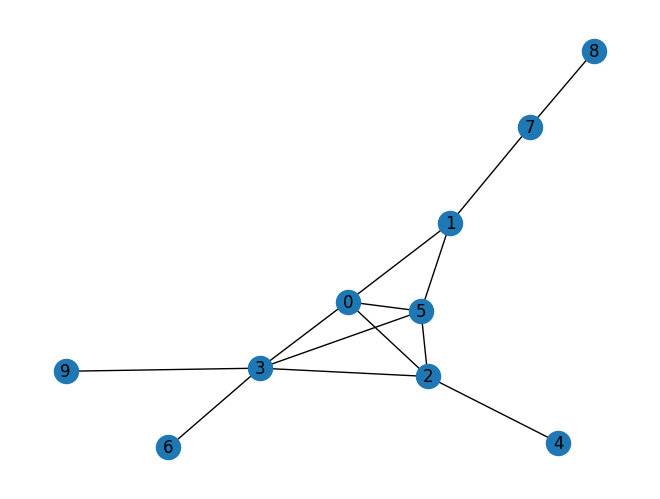

In [8]:
import networkx as nx
import numpy as np

from sklearn.preprocessing import normalize

nx_g = nx.Graph()

nx_g.add_edges_from([(0, 1), (0, 2),  (2, 3), (2, 4), (3,5 ), (0,3), (0,5), (1,5), (3,6), (2,5), (1,7),(8,7), (3,9)])
nx.draw(nx_g,with_labels = True)
num_nodes = 10

In [17]:
Ak = np.matrix(np.identity(num_nodes))
adj = normalize(adj, axis=1, norm='l1')
adj = np.round(adj,2)
adj

array([[0.  , 0.25, 0.25, 0.25, 0.  , 0.25, 0.  , 0.  , 0.  , 0.  ],
       [0.33, 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.33, 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.25, 0.25, 0.25, 0.  , 0.  , 0.  , 0.  ],
       [0.2 , 0.  , 0.2 , 0.  , 0.  , 0.2 , 0.2 , 0.  , 0.  , 0.2 ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [18]:
Ak = np.matrix(np.identity(num_nodes))


In [20]:
for i in range(4):
    Ak = np.dot(Ak, adj)
    print(f'Step: {i+1}')
    print(np.round(Ak,2))

step: 1
[[0.12 0.15 0.2  0.24 0.03 0.14 0.02 0.02 0.04 0.02]
 [0.2  0.04 0.07 0.08 0.04 0.2  0.03 0.27 0.   0.03]
 [0.2  0.06 0.08 0.26 0.11 0.2  0.02 0.04 0.   0.02]
 [0.19 0.05 0.21 0.08 0.02 0.19 0.11 0.03 0.   0.11]
 [0.11 0.12 0.42 0.12 0.   0.11 0.05 0.   0.   0.05]
 [0.14 0.15 0.2  0.24 0.03 0.12 0.02 0.02 0.04 0.02]
 [0.1  0.1  0.1  0.55 0.05 0.1  0.   0.   0.   0.  ]
 [0.04 0.42 0.08 0.08 0.   0.04 0.   0.   0.33 0.  ]
 [0.16 0.   0.   0.   0.   0.16 0.   0.66 0.   0.  ]
 [0.1  0.1  0.1  0.55 0.05 0.1  0.   0.   0.   0.  ]]
step: 2
[[0.18 0.08 0.14 0.17 0.05 0.18 0.05 0.09 0.01 0.05]
 [0.1  0.24 0.16 0.19 0.02 0.1  0.02 0.01 0.14 0.02]
 [0.14 0.12 0.26 0.17 0.02 0.14 0.05 0.02 0.02 0.05]
 [0.13 0.11 0.14 0.37 0.05 0.13 0.02 0.02 0.02 0.02]
 [0.2  0.06 0.08 0.26 0.11 0.2  0.02 0.04 0.   0.02]
 [0.18 0.08 0.14 0.17 0.05 0.18 0.05 0.09 0.01 0.05]
 [0.19 0.05 0.21 0.08 0.02 0.19 0.11 0.03 0.   0.11]
 [0.18 0.02 0.04 0.04 0.02 0.18 0.02 0.47 0.   0.02]
 [0.04 0.42 0.08 0.08 0.   0.

# 3. Grarep

In [ ]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import sparse
from sklearn.decomposition import TruncatedSVD

In [ ]:
class GraRep(object):
    def __init__(self, A, args):
        """
        :param A: Adjacency matrix.
        :param args: Arguments object.
        """
        self.A = A
        self.args = args
        self._setup_base_target_matrix()

    def _setup_base_target_matrix(self):
        """
        Creating a base matrix to multiply.
        """
        values = [1.0 for _ in range(self.A.shape[0])]
        indices = [i for i in range(self.A.shape[0])]
        self.A_hat = sparse.coo_matrix((values, (indices, indices)),
                                       shape=self.A.shape,
                                       dtype=np.float32)

    def _create_target_matrix(self):
        """
        Creating a log transformed target matrix.
        :return target_matrix: Matrix to decompose with SVD.
        """
        self.A_hat = sparse.coo_matrix(self.A_hat.dot(self.A))
        scores = np.log(self.A_hat.data)-math.log(self.A.shape[0])
        rows = self.A_hat.row[scores < 0]
        cols = self.A_hat.col[scores < 0]
        scores = scores[scores < 0]
        target_matrix = sparse.coo_matrix((scores, (rows, cols)),
                                          shape=self.A.shape,
                                          dtype=np.float32)
        return target_matrix

    def optimize(self):
        """
        Learning an embedding.
        """
        print("\nOptimization started.\n")
        self.embeddings = []
        for step in tqdm(range(self.args["order"])):
            target_matrix = self._create_target_matrix()

            svd = TruncatedSVD(n_components=self.args["dim"],
                               n_iter=self.args["iter"],
                               random_state=self.args["seed"])

            svd.fit(target_matrix)
            embedding = svd.transform(target_matrix)
            self.embeddings.append(embedding)

    def return_embedding(self):
        """
        Return the embedding.
        """
        print("\nReturn embedding.\n")
        self.embeddings = np.concatenate(self.embeddings, axis=1)
        column_count = self.args["order"] * self.args["dim"]
        columns = ["ID"] + ["x_" + str(col) for col in range(column_count)]
        ids = np.array([i for i in range(self.A.shape[0])]).reshape(-1,1)
        self.embeddings = np.concatenate([ids, self.embeddings], axis=1)
        self.embeddings = pd.DataFrame(self.embeddings, columns=columns)
        
        return self.embeddings

In [ ]:
args = {
    "dim": 16,
    "order": 5,
    "seed": 42,
    "iter": 20
}

grarep = GraRep(cora_A, args)

grarep.optimize()

In [ ]:
grarep_emb_csv = grarep.return_embedding()

In [ ]:
grarep_emb_csv.head()

# 4. Metapath2vec

In [ ]:
import torch
from torch_geometric.nn.models import MetaPath2Vec

In [ ]:
metapath = [
    ('author', 'writes', 'paper'),
    ('paper', 'published_in', 'venue'),
    ('venue', 'publishes', 'paper'),
    ('paper', 'written_by', 'author'),
]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MetaPath2Vec(aminer_data.edge_index_dict, embedding_dim=128,
                     metapath=metapath, walk_length=50, context_size=7,
                     walks_per_node=5, num_negative_samples=5,
                     sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=6)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [ ]:
def train(epoch, log_steps=100, eval_steps=2000):
    model.train()

    total_loss = 0
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_steps == 0:
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Loss: {total_loss / log_steps:.4f}'))
            total_loss = 0

        if (i + 1) % eval_steps == 0:
            acc = test()
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Acc: {acc:.4f}'))


@torch.no_grad()
def test(train_ratio=0.1):
    model.eval()

    z = model('author', batch=aminer_data['author'].y_index.to(device))
    y = aminer_data['author'].y

    perm = torch.randperm(z.size(0))
    train_perm = perm[:int(z.size(0) * train_ratio)]
    test_perm = perm[int(z.size(0) * train_ratio):]

    return model.test(z[train_perm], y[train_perm], z[test_perm], y[test_perm],
                      max_iter=150)

In [ ]:
for epoch in range(5):
    train(epoch)
    acc = test()
    print(f'Epoch: {epoch}, Accuracy: {acc:.4f}')

# 5. WL-relabeling

In [ ]:
def wlk_relabel(g,h):
    '''
    Perform node relabeling (coloring) according 1-d WL relabeling process (refer Shervashidze et al (2009) paper)
    :param g: networkx graph
    :param h: height of WL kernel
    :return: relabeled graph
    '''
    for i in range(len(g.nodes)):
        g.nodes[i]['relabel'] = {}
        
    for i in range(0,h+1): #xrange returns [min,max)
        for n in range(len(g.nodes)):
            # degree_prefix = 'D' + str(i)
            degree_prefix = ''
            if 0 == i:
                g.nodes[n]['relabel'][0] = degree_prefix + str(g.nodes[n]['label']).strip() + degree_prefix
            else:
                nei_labels = [g.nodes[nei]['relabel'][i-1] for nei in nx.all_neighbors(g,n)]
                nei_labels.sort()
                sorted_nei_labels = (','*i).join(nei_labels)

                current_in_relabel = g.nodes[n]['relabel'][i-1] +'#'*i+ sorted_nei_labels
                g.nodes[n]['relabel'][i] = degree_prefix + current_in_relabel.strip() + degree_prefix
    return g #relabled graph

In [ ]:
def fill_labels(G):
    for i in range(len(G.nodes)):
        G.nodes[i]['label'] = '1'

In [ ]:
def draw_graph(G):
    clubs = []  # list to populate with labels
    for n in G.nodes:
        c = G.nodes[n]['relabel']
        print(f'Node ID {n}: colour: {c}')
        col = 0
        if c=='1':
            clubs.append('green')
        elif c =='2':
            clubs.append('red')
        else:
            clubs.append('gray')
    pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
    nx.draw_networkx(G, pos=pos, node_color = clubs) # Plot the graph

In [ ]:
G = nx.Graph([
    (0, 1),
    (1 ,2), 
    (1 ,3),
    (1 ,5),
    (2 ,3),
    (2 ,4),
    (2 ,6),
    (3 ,4),
    (3 ,5),
    (4 ,7),
    (4 ,8),
    (6 ,7)])
fill_labels(G)
nx.draw(G, with_labels = True)

In [ ]:
relabeled_G = wlk_relabel(G, 1)

In [ ]:
draw_graph(relabeled_G)